In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [16]:
START_DATE = '2015-01-01'
END_DATE = '2025-12-12'

In [35]:
hsi = yf.download('^HSI', START_DATE, END_DATE)

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_48848/1293430397.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hsi = yf.download('^HSI', START_DATE, END_DATE)
[*********************100%***********************]  1 of 1 completed


In [17]:
hsi_stocks = pd.read_excel('/Users/henrywzh/Desktop/hk_stock_efjq.xlsx')
hsi_stocks

,代码,名称,信号,股价,DayChangePct,FiveDayPct,OneMonthPct,Dev10Pct,Dev50Pct,VolumeRatio,Beta,RSI14,SignalDate,转灯,转灯表现
0,9999,網易-Ｓ,沒有警號,218.40,0.042,0.002,0.010,0.009,-0.017,2.5,1.1,51.6,2025-12-09,-1,0.027
1,9992,泡泡瑪特,沒有警號,194.10,0.004,0.114,0.118,-0.055,-0.147,0.5,1.1,36.9,2025-10-27,-1,-0.168
2,9988,阿里巴巴-Ｗ,沒有警號,154.10,0.023,0.006,0.017,0.003,-0.042,0.8,1.8,48.3,2025-07-25,1,0.306
3,9961,攜程集團-Ｓ,沒有警號,550.00,0.016,0.008,0.040,0.008,-0.006,1.0,1.1,50.4,2025-07-22,1,0.105
4,9901,新東方-Ｓ,沒有警號,42.02,0.004,0.015,0.022,0.014,-0.008,0.8,1.0,53.6,2025-09-11,1,-0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,772,閱文集團,沒有警號,34.40,0.058,0.058,0.057,0.137,-0.027,3.8,1.1,41.1,2025-04-07,-1,0.515
104,763,中興通訊,沒有警號,28.60,0.040,0.040,0.117,0.059,-0.104,1.4,1.4,39.1,2025-04-09,-1,0.402
105,522,ASMPT,沒有警號,78.75,-0.001,-0.001,0.002,0.007,0.011,0.5,0.9,52.2,2025-07-16,1,0.290
106,268,金蝶國際,沒有警號,13.22,-0.024,-0.024,0.047,0.131,-0.030,2.4,1.6,38.2,2025-10-27,-1,-0.084


In [18]:
def code_int_to_hk(code: int) -> str:
    # 9 -> 0009.HK, 9999 -> 9999.HK
    return f"{int(code):04d}.HK"

UNIVERSE = hsi_stocks['代码'].apply(code_int_to_hk).tolist()

In [25]:
price_df = yf.download(UNIVERSE, START_DATE, END_DATE)
price_df.info()

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_48848/3543066979.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_df = yf.download(UNIVERSE, START_DATE, END_DATE)
[*********************100%***********************]  108 of 108 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2697 entries, 2015-01-02 to 2025-12-11
Columns: 540 entries, ('Close', '0001.HK') to ('Volume', '9999.HK')
dtypes: float64(468), int64(72)
memory usage: 11.1 MB


In [76]:
# =======================================================
# 1. Build MA signal   (unchanged, safe for NaN handling)
# =======================================================

def build_ma_signal(price_df, windows=(10, 20, 50, 120)):
    close = price_df['Close'].sort_index()

    ma_sum = 0
    for w in windows:
        ma = close.rolling(w, min_periods=w).mean()
        ma_sum += (close / ma - 1)

    signal = ma_sum / len(windows)
    return signal   # shape (T, N)


# =======================================================
# 2. Bucket backtest with strict NaN filtering
# =======================================================

def bucket_backtest(price_df, signal, H=1, n_buckets=10):
    """
    price_df  : MultiIndex ('Close', ticker)
    signal    : DataFrame (dates x tickers)
    H         : rebalance period (e.g. 1 = daily)
    n_buckets : number of quantile groups
    """

    close = price_df["Close"].sort_index()

    # next-day return, safe for NaN stocks
    ret_next = close.pct_change(fill_method=None).shift(-1)

    dates = close.index
    n_dates = len(dates)

    # Rebalance dates
    rebalance_mask = np.zeros(n_dates, dtype=bool)
    rebalance_mask[::H] = True
    rebalance_dates = dates[rebalance_mask]

    # Output containers
    bucket_ret = {f"bucket_{k}": [] for k in range(1, n_buckets+1)}
    out_dates = []

    # Bucket labels for analysis (NaN for excluded tickers)
    bucket_lbl = pd.DataFrame(index=dates, columns=signal.columns, dtype=float)

    # Loop through each rebalance date
    for t in rebalance_dates:
        sig_t = signal.loc[t]

        # =========================================
        # IMPORTANT: exclude tickers with NaN signal or NaN price
        # =========================================
        valid_mask = (~sig_t.isna()) & (~close.loc[t].isna())
        valid_tickers = sig_t.index[valid_mask]

        if len(valid_tickers) == 0:
            # No tradable stocks at this date
            continue

        sig_valid = sig_t[valid_tickers]

        # Rank: high signal = high rank
        ranks = sig_valid.rank(ascending=False, method='first')

        # Assign buckets
        n_valid = len(valid_tickers)
        bucket_size = n_valid / n_buckets

        bucket_ids = ((ranks - 1) / bucket_size).astype(int) + 1
        bucket_ids = bucket_ids.clip(1, n_buckets)

        # Save labels to full matrix
        bucket_lbl.loc[t, valid_tickers] = bucket_ids

        # Earn next-day return
        rnext_t = ret_next.loc[t, valid_tickers]

        # Compute bucket-level equal-weight return
        for k in range(1, n_buckets + 1):
            mask_k = (bucket_ids == k)
            if isinstance(mask_k.dtype, pd.BooleanDtype):
                mask_k = mask_k.fillna(False)
            members = bucket_ids.index[mask_k]
            if len(members) == 0:
                bucket_ret[f"bucket_{k}"].append(np.nan)
            else:
                bucket_ret[f"bucket_{k}"].append(rnext_t[members].mean())

        out_dates.append(t)

    # Convert bucket returns to DataFrame
    bucket_ret = pd.DataFrame(bucket_ret, index=out_dates)

    # Forward-fill bucket labels for entire trading period
    bucket_lbl = bucket_lbl.ffill()

    return bucket_ret, bucket_lbl, ret_next


In [107]:
# ---------------------------
# 3. Putting it all together
# ---------------------------

# Example usage with your price_df
signal = build_ma_signal(price_df, windows=(5, 20, 50, 120))

# e.g. H = 1 (rebalance every day); you can change to H=5, 10, 20, etc.
bucket_ret, bucket_lbl, ret_next = bucket_backtest(
    price_df,
    signal,
    H=1,
    n_buckets=10
)

# Cumulative returns per bucket (for inspection)
cum_bucket = (1 + bucket_ret.fillna(0)).cumprod()


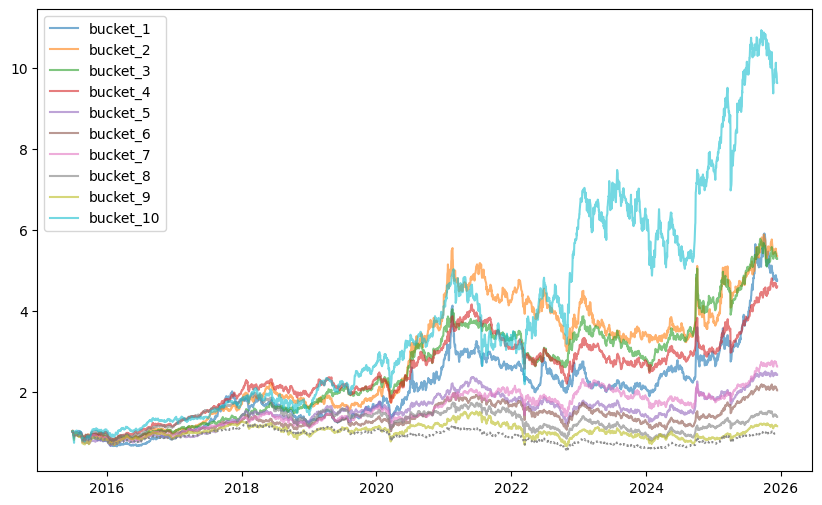

In [109]:
hsi_ret = hsi['Close'].pct_change()
hsi_ret = hsi_ret[(cum_bucket.index[0] <= hsi_ret.index) & (hsi_ret.index <= cum_bucket.index[-1])]
hsi_cum_ret = (1 + hsi_ret).cumprod()

plt.figure(figsize=(10, 6))
for bucket in cum_bucket.columns:
    plt.plot(cum_bucket[bucket], alpha=0.6, label=bucket)

plt.plot(hsi_cum_ret, alpha=0.9, linestyle=':', color='gray')
plt.legend()

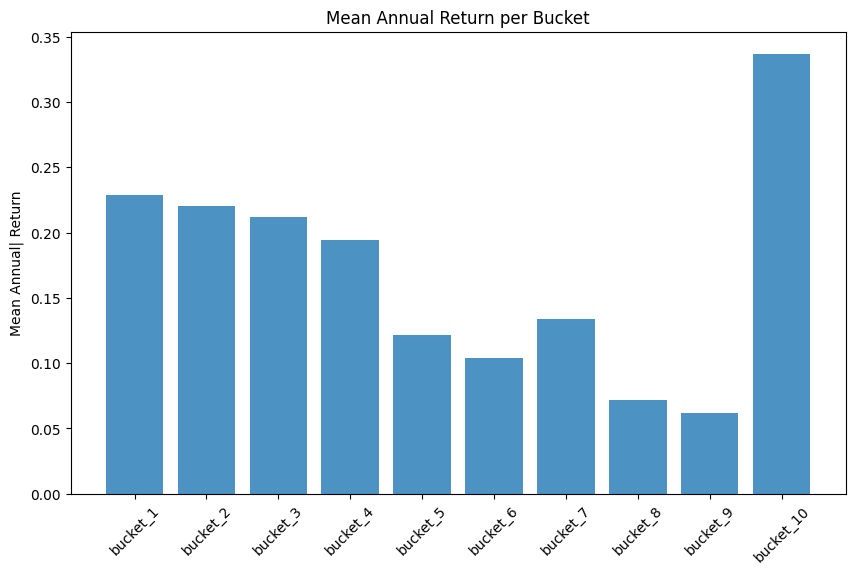

In [111]:
mean_bucket_ret = bucket_ret.mean()
TRADING_DAYS = 252
ann_mean_bucket_ret = (1 + mean_bucket_ret)**TRADING_DAYS - 1

plt.figure(figsize=(10, 6))
plt.bar(ann_mean_bucket_ret.index, ann_mean_bucket_ret.values, alpha=0.8)
plt.title("Mean Annual Return per Bucket")
plt.ylabel("Mean Annual| Return")
plt.xticks(rotation=45)
plt.show()


In [112]:
def compute_ic_series(bucket_lbl, ret_next, rebalance_dates, method="spearman"):
    """
    method: 'spearman' recommended for robustness
    """
    ic_list = []

    for t in rebalance_dates:
        if t not in bucket_lbl.index or t not in ret_next.index:
            continue

        lbl_t = bucket_lbl.loc[t]
        r_t = ret_next.loc[t]

        # valid stocks for IC: must have bucket label AND next return
        valid = (~lbl_t.isna()) & (~r_t.isna())
        if valid.sum() < 20:  # too few names -> skip
            continue

        lbl_t = lbl_t[valid]
        r_t = r_t[valid]

        # build double-tail score per stock
        score = pd.Series(0.0, index=lbl_t.index)
        score[lbl_t == 10] = 1.0
        score[lbl_t == 1]  = 1.0
        score[lbl_t.isin([4,5,6,7,8])] = -1.0
        
        if score.nunique() < 2 or r_t.nunique() < 2:
            continue

        # correlation across stocks for that date
        if method == "spearman":
            ic = score.rank().corr(r_t.rank())
        else:
            ic = score.corr(r_t)

        ic_list.append((t, ic))

    ic_s = pd.Series(dict(ic_list)).sort_index()
    return ic_s

def icir(ic_series):
    ic_series = ic_series.dropna()
    if len(ic_series) < 2:
        return np.nan
    return ic_series.mean() / ic_series.std(ddof=0)

def annualised_return(r, freq=TRADING_DAYS):
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    return (1 + r.mean())**freq - 1

def annualised_vol(r, freq=TRADING_DAYS):
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    return r.std(ddof=0) * np.sqrt(freq)

def sharpe_ratio(r, freq=TRADING_DAYS, rf=0.0):
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    ex = r - rf/freq
    vol = ex.std(ddof=0) * np.sqrt(freq)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return (ex.mean() * freq) / vol

def rolling_sharpe(r, window=252, freq=TRADING_DAYS, rf=0.0):
    # Rolling annualised Sharpe using rolling mean/std of daily returns
    ex = r - rf/freq
    mu = ex.rolling(window).mean() * freq
    vol = ex.rolling(window).std(ddof=0) * np.sqrt(freq)
    return mu / vol

In [117]:
def compute_double_tail(bucket_ret):
    b1_2  = (bucket_ret["bucket_1"] + bucket_ret["bucket_2"]) / 2
    b10 = bucket_ret["bucket_10"]
    mid = bucket_ret[["bucket_6","bucket_7","bucket_8","bucket_9"]].mean(axis=1)
    dt = (b1_2 + b10) / 2 - mid
    return dt


Mean IC: -0.008116908877117376
ICIR: -0.05724608585610814


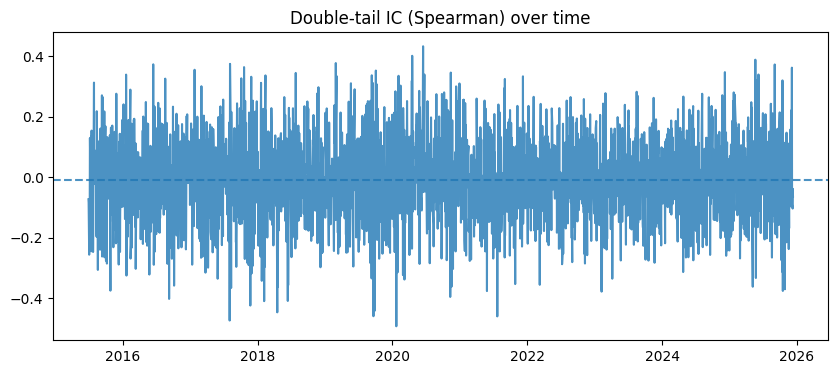

In [118]:
# run one configuration
windows = (5,20,50,120)
H = 1

signal = build_ma_signal(price_df, windows)
bucket_ret, bucket_lbl, ret_next = bucket_backtest(price_df, signal, H=H, n_buckets=10)
double_tail = compute_double_tail(bucket_ret)

rebalance_dates = price_df["Close"].index[::H]
ic_s = compute_ic_series(bucket_lbl, ret_next, rebalance_dates, method="spearman")

print("Mean IC:", ic_s.mean())
print("ICIR:", icir(ic_s))

plt.figure(figsize=(10,4))
plt.plot(ic_s, alpha=0.8)
plt.axhline(ic_s.mean(), linestyle="--", alpha=0.8)
plt.title("Double-tail IC (Spearman) over time")
plt.show()



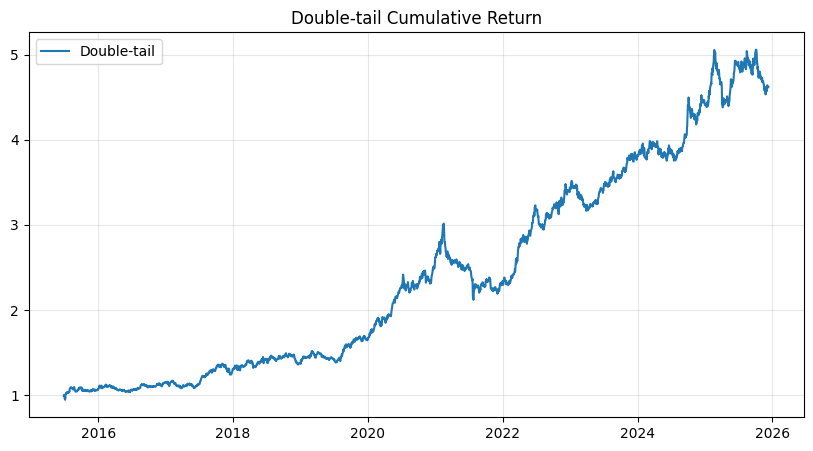

In [119]:
dt = double_tail.dropna()
dt_cum = (1 + dt).cumprod()

plt.figure(figsize=(10,5))
plt.plot(dt_cum, label="Double-tail")
plt.title("Double-tail Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

2015    0.064302
2016    0.076367
2017    0.137911
2018    0.058312
2019    0.210462
2020    0.569832
2021   -0.108291
2022    0.470868
2023    0.108743
2024    0.156570
2025    0.048050


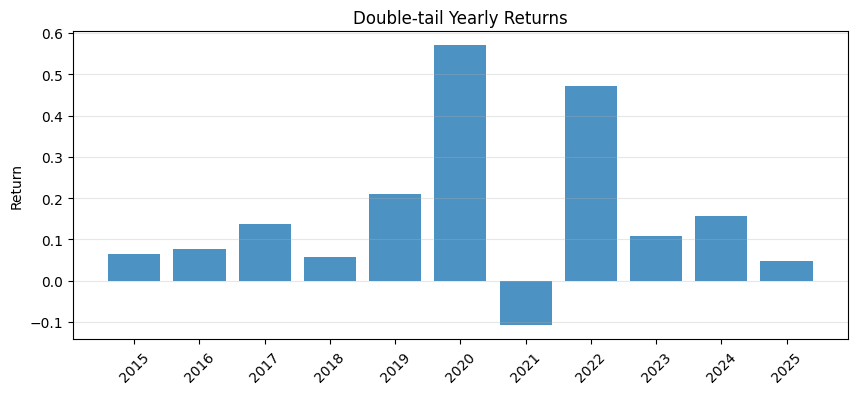

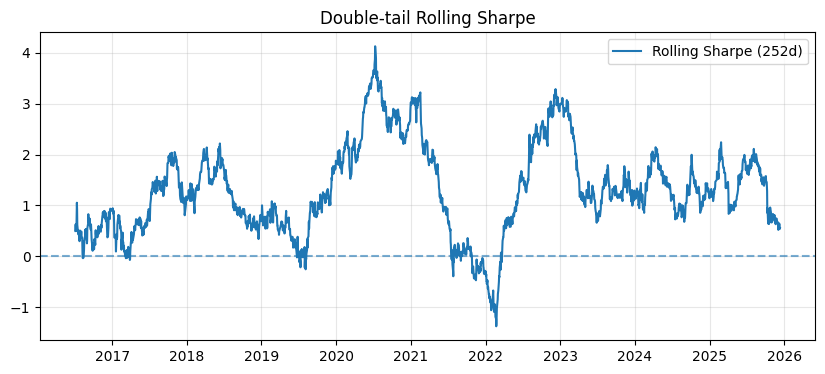

In [120]:
# yearly compounded return
yearly = (1 + dt).groupby(dt.index.year).prod() - 1
yearly.name = "year_return"

print(yearly.to_string())

plt.figure(figsize=(10,4))
plt.bar(yearly.index.astype(str), yearly.values, alpha=0.8)
plt.title("Double-tail Yearly Returns")
plt.ylabel("Return")
plt.xticks(rotation=45)
plt.grid(True, axis="y", alpha=0.3)
plt.show()

rs = rolling_sharpe(dt, window=252, freq=TRADING_DAYS)

plt.figure(figsize=(10,4))
plt.plot(rs, label="Rolling Sharpe (252d)")
plt.axhline(0, linestyle="--", alpha=0.6)
plt.title("Double-tail Rolling Sharpe")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [78]:
from itertools import product

short_candidates = [5, 10]
med_candidates   = [20, 30]
long_candidates  = [50, 60]
xl_candidates    = [120, 250]

def valid_windows(ws):
    return ws[0] < ws[1] < ws[2] < ws[3]

def evaluate_config(price_df, windows, H, n_buckets=10):
    signal = build_ma_signal(price_df, windows)
    bucket_ret, bucket_lbl, ret_next = bucket_backtest(price_df, signal, H=H, n_buckets=n_buckets)
    dt = compute_double_tail(bucket_ret).dropna()

    # strategy stats
    ann_ret = annualised_return(dt)
    ann_vol = annualised_vol(dt)
    sr = sharpe_ratio(dt)

    # IC stats
    rebalance_dates = price_df["Close"].index[::H]
    ic_s = compute_ic_series(bucket_lbl, ret_next, rebalance_dates, method="spearman")
    ic_mean = ic_s.mean()
    ic_ir = icir(ic_s)

    return {
        "windows": windows,
        "H": H,
        "ann_return": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sr,
        "ic_mean": ic_mean,
        "icir": ic_ir,
        "n_obs": len(dt),
        "ic_n": ic_s.dropna().shape[0],
    }

In [79]:
Hs = [1, 5, 10, 20]

rows = []
for H in Hs:
    for ws in product(short_candidates, med_candidates, long_candidates, xl_candidates):
        if not valid_windows(ws):
            continue
        rows.append(evaluate_config(price_df, ws, H))

res = pd.DataFrame(rows)

# choose objective: Sharpe by default
res_sorted = res.sort_values(["sharpe", "icir"], ascending=False)
print(res_sorted.head(10))


              windows  H  ann_return   ann_vol    sharpe   ic_mean      icir  \
16   (5, 20, 50, 120)  5    0.345131  0.157844  1.879484 -0.001664 -0.011977   
28  (10, 30, 50, 120)  5    0.342923  0.158859  1.857127 -0.002301 -0.016699   
19   (5, 20, 60, 250)  5    0.315330  0.150059  1.827522 -0.001907 -0.013171   
20   (5, 30, 50, 120)  5    0.329533  0.157286  1.811909 -0.001903 -0.013903   
18   (5, 20, 60, 120)  5    0.322084  0.157540  1.773293 -0.002180 -0.015505   
27  (10, 20, 60, 250)  5    0.278132  0.148916  1.648716 -0.002315 -0.015993   
26  (10, 20, 60, 120)  5    0.297028  0.159820  1.628141 -0.003698 -0.026439   
22   (5, 30, 60, 120)  5    0.287322  0.157270  1.606728 -0.004482 -0.032645   
24  (10, 20, 50, 120)  5    0.287364  0.159676  1.582727 -0.004157 -0.030001   
29  (10, 30, 50, 250)  5    0.265923  0.150696  1.565480 -0.004028 -0.028071   

    n_obs  ic_n  
16    516   516  
28    516   516  
19    490   490  
20    516   516  
18    516   516  
27    490  

BEST windows: (5, 20, 50, 120) BEST H: 5
windows       (5, 20, 50, 120)
H                            5
ann_return            0.345131
ann_vol               0.157844
sharpe                1.879484
ic_mean              -0.001664
icir                 -0.011977
n_obs                      516
ic_n                       516
Name: 16, dtype: object


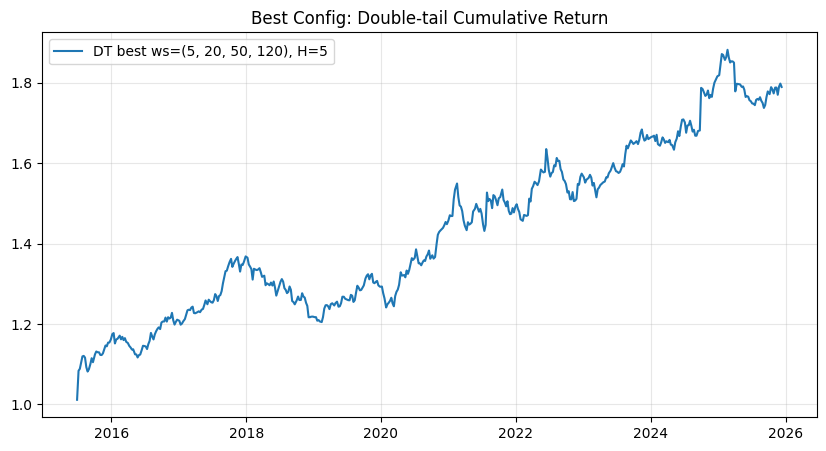

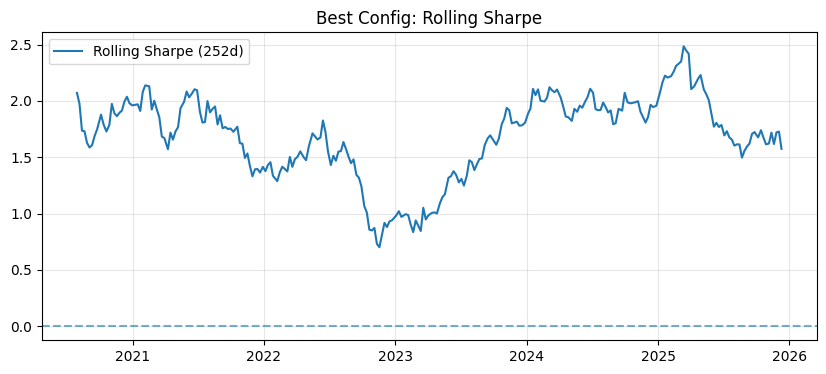

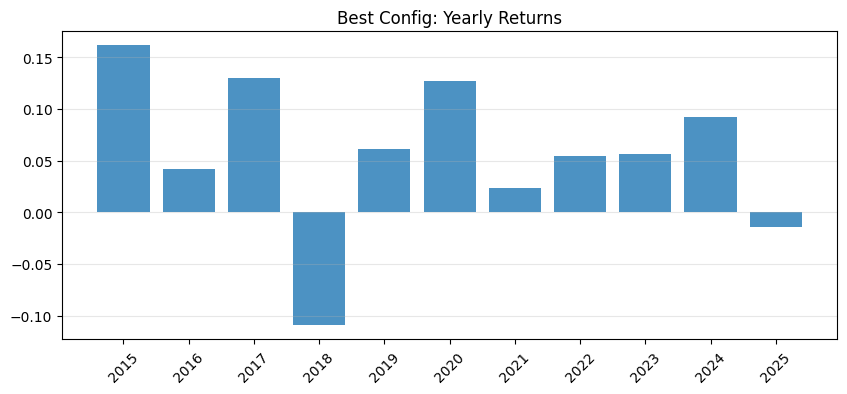

In [80]:
best = res_sorted.iloc[0]
best_windows = tuple(best["windows"])
best_H = int(best["H"])

print("BEST windows:", best_windows, "BEST H:", best_H)
print(best)

# rerun best and plot
signal = build_ma_signal(price_df, best_windows)
bucket_ret, bucket_lbl, ret_next = bucket_backtest(price_df, signal, H=best_H, n_buckets=10)
dt = compute_double_tail(bucket_ret).dropna()

# cum
plt.figure(figsize=(10,5))
plt.plot((1+dt).cumprod(), label=f"DT best ws={best_windows}, H={best_H}")
plt.title("Best Config: Double-tail Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# rolling sharpe
plt.figure(figsize=(10,4))
plt.plot(rolling_sharpe(dt, 252), label="Rolling Sharpe (252d)")
plt.axhline(0, linestyle="--", alpha=0.6)
plt.title("Best Config: Rolling Sharpe")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# yearly
yearly = (1 + dt).groupby(dt.index.year).prod() - 1
plt.figure(figsize=(10,4))
plt.bar(yearly.index.astype(str), yearly.values, alpha=0.8)
plt.title("Best Config: Yearly Returns")
plt.xticks(rotation=45)
plt.grid(True, axis="y", alpha=0.3)
plt.show()


In [ ]:
sp500 = yf.download('^GSPC', start=START_DATE, end=END_DATE)['Close']

